<a href="https://colab.research.google.com/github/rintasn/aop_ds/blob/main/20230829_manufacturing_predictive_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis Case in Manufacturing : Predictive Maintenance

author: Ardya Dipta Nandaviri (ardyadipta@gmail.com) | [Linkedin](https://www.linkedin.com/in/ardyadipta/)
date: Aug 29, 2023

python version: 3.10.11

## Objectives

    * To exercise on exploratory data analysis and predictive analytics on example case on manufacturing


## Dataset information

* Link to dataset [link](https://drive.google.com/file/d/14jJBPk60BGmRHEu9mI6DtBDWSM9bZVgg/view?usp=drive_link)


The dataset consists of 10 000 data points stored as rows with 14 features in columns:


        * UID: unique identifier ranging from 1 to 10000  
        * product ID: consisting of a letter L, M, or H for
            low (50% of all products),
            medium (30%)
            high (20%) as product quality variants and a variant-specific serial number  
        * air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
        * process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K,
            added to the air temperature plus 10 K.
        * rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
        * torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.
        * tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
        * 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.
    
The machine failure consists of five independent failure modes:

    * tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time
        between 200 â€“ 240 mins (120 times in our dataset).
        At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
    * heat dissipation failure (HDF): heat dissipation causes a process failure,
        if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm.
        This is the case for 115 data points.
    * power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process.
        If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
    * overstrain failure (OSF): if the product of tool wear and torque
        exceeds 11,000 minNm for the L product variant
        (12,000 M, 13,000 H), the process fails due to overstrain.
        This is true for 98 datapoints.
    * random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters.
        This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.
    
    If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail

## Acknowledgements

* AI4I 2020 Predictive Maintenance Dataset by UC Irvine Machine Learning Repo [[link](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset)]
* Kaggle machine predictive maintenance classification [[link](https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020?datasetId=2609801&sortBy=voteCount)]

* S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

In [ ]:
! pip install numpy pandas seaborn matplotlib category_encoders missingno


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Default theme
sns.set_theme(palette='tab10',
              # font='Lucida Calligraphy',
              font_scale=1.5,
              rc=None)

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
# plt.style.use('dark_background')
plt.style.use('seaborn')

In [ ]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df=pd.read_csv("/content/ai4i2020_modified.csv")
df = df.drop(["UDI","Product ID"],axis=1)
df.sample(6).style.set_properties(
    **{
        'background-color': 'Brown',
        'color': 'white',
        'border-color': 'White'
    })

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
6400,L,300.100000,309.700000,1601,35.800000,160,0,No Failure
1184,L,297.300000,308.500000,1497,47.500000,27,0,No Failure
1006,L,296.200000,307.100000,1413,53.400000,203,0,No Failure
6636,M,301.500000,310.500000,1774,25.500000,121,0,No Failure
3864,M,302.500000,311.400000,1629,31.700000,225,0,No Failure
9908,L,298.600000,309.000000,1456,47.700000,0,0,No Failure


In [ ]:
## Converting temperature in centigrate from Kelvin [1 K = -272.15 °C  ]

df["Air temperature [K]"] = df["Air temperature [K]"] - 272.15
df["Process temperature [K]"] = df["Process temperature [K]"] - 272.15

# Renaming temperature in Centigrate(°C) from Kelvin (K)
df.rename(columns={"Air temperature [K]" : "Air temperature [°C]","Process temperature [K]" : "Process temperature [°C]"},inplace=True)

In [ ]:
df["Temperature difference [°C]"] = df["Process temperature [°C]"] - df["Air temperature [°C]"]
df.sample(5)

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
6789,M,28.95,38.35,1646,30.7,76,0,No Failure,9.4
7178,L,28.05,38.05,1600,31.5,23,0,No Failure,10.0
7075,L,28.55,38.35,1536,47.4,192,0,No Failure,9.8
9181,L,25.75,36.95,1521,36.1,15,0,No Failure,11.2
5257,L,31.35,40.85,1482,38.5,82,0,No Failure,9.5


In [ ]:
display(df.shape)
display(df.size)

(10000, 9)

90000

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Type                         10000 non-null  object 
 1   Air temperature [°C]         10000 non-null  float64
 2   Process temperature [°C]     10000 non-null  float64
 3   Rotational speed [rpm]       10000 non-null  int64  
 4   Torque [Nm]                  10000 non-null  float64
 5   Tool wear [min]              10000 non-null  int64  
 6   Target                       10000 non-null  int64  
 7   Failure Type                 10000 non-null  object 
 8   Temperature difference [°C]  10000 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 703.2+ KB


In [ ]:
df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Air temperature [°C],10000.000000,27.854930,2.000259,23.150000,26.150000,27.950000,29.350000,32.350000
Process temperature [°C],10000.000000,37.855560,1.483734,33.550000,36.650000,37.950000,38.950000,41.650000
Rotational speed [rpm],10000.000000,1538.776100,179.284096,1168.000000,1423.000000,1503.000000,1612.000000,2886.000000
Torque [Nm],10000.000000,39.986910,9.968934,3.800000,33.200000,40.100000,46.800000,76.600000
Tool wear [min],10000.000000,107.951000,63.654147,0.000000,53.000000,108.000000,162.000000,253.000000
Target,10000.000000,0.033900,0.180981,0.000000,0.000000,0.000000,0.000000,1.000000
Temperature difference [°C],10000.000000,10.000630,1.001094,7.600000,9.300000,9.800000,11.000000,12.100000


This descriptive statistics is very important to understand the distribution of each varialble.

# Exploratory Data Analysis

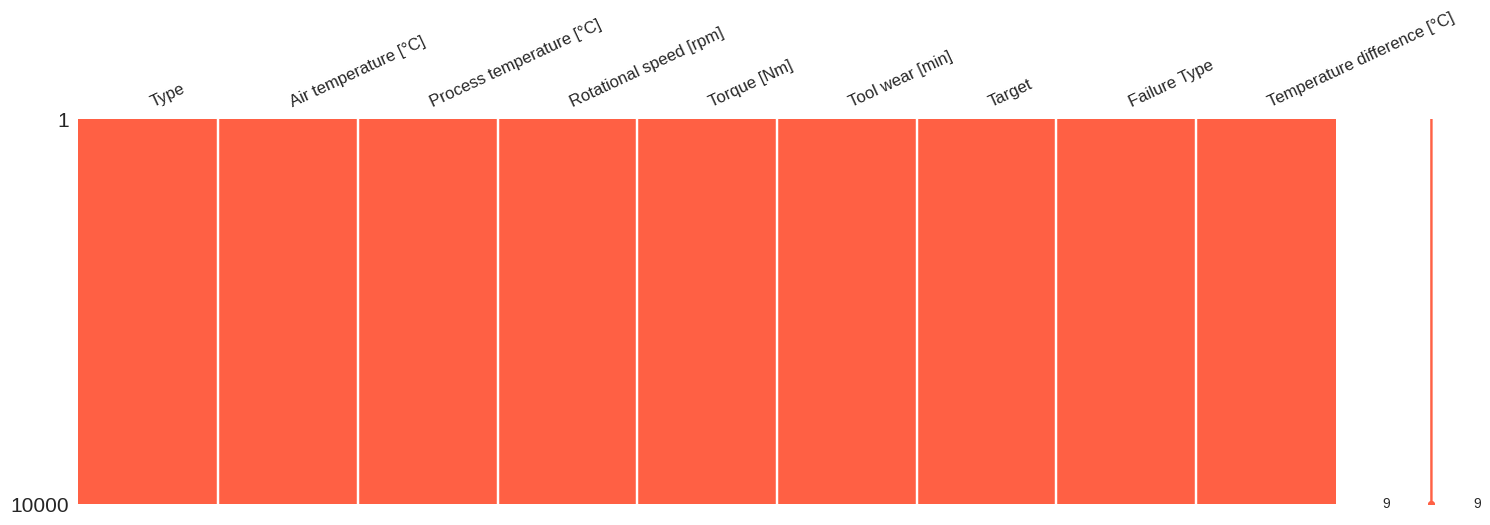

In [ ]:
import missingno as msno
msno.matrix(df, figsize=(18,5), fontsize=12, color=(1, 0.38, 0.27));
plt.xticks(rotation=25);

From the dataset there is no missing value

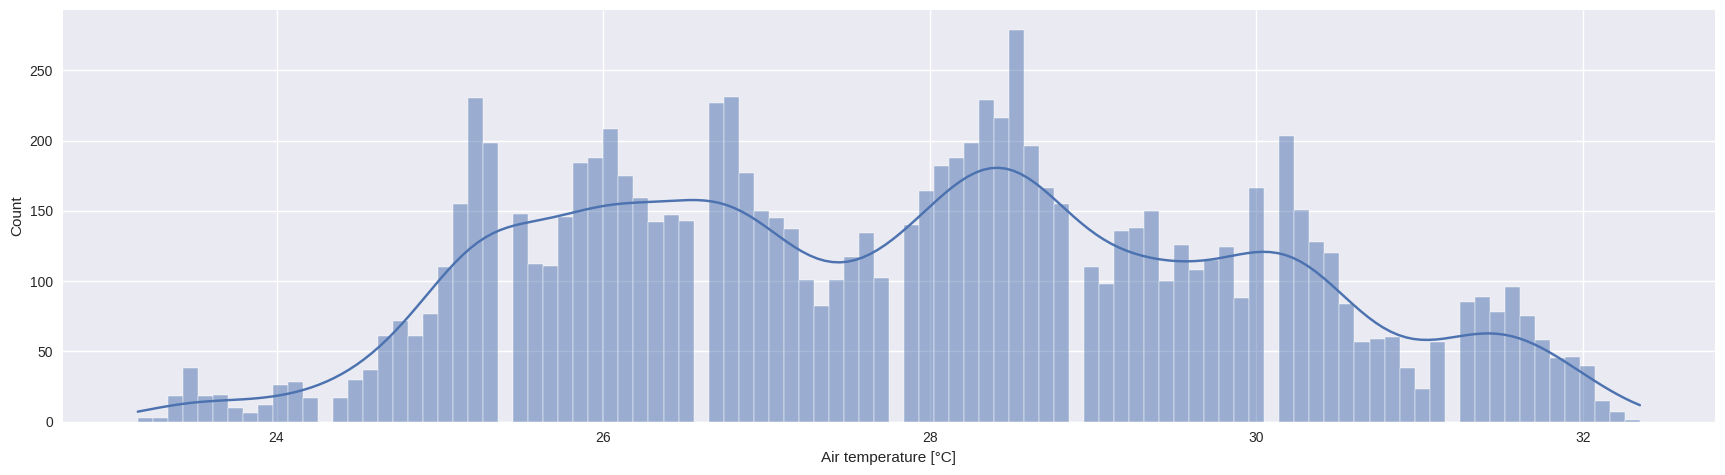

In [ ]:
# sns.displot(data=df, x="Air temperature [°C]", kde=True, bins = 100,color = "red", facecolor = "yellow",height = 5, aspect = 3.5);
sns.displot(data=df, x="Air temperature [°C]", kde=True, bins = 100,height = 5, aspect = 3.5);

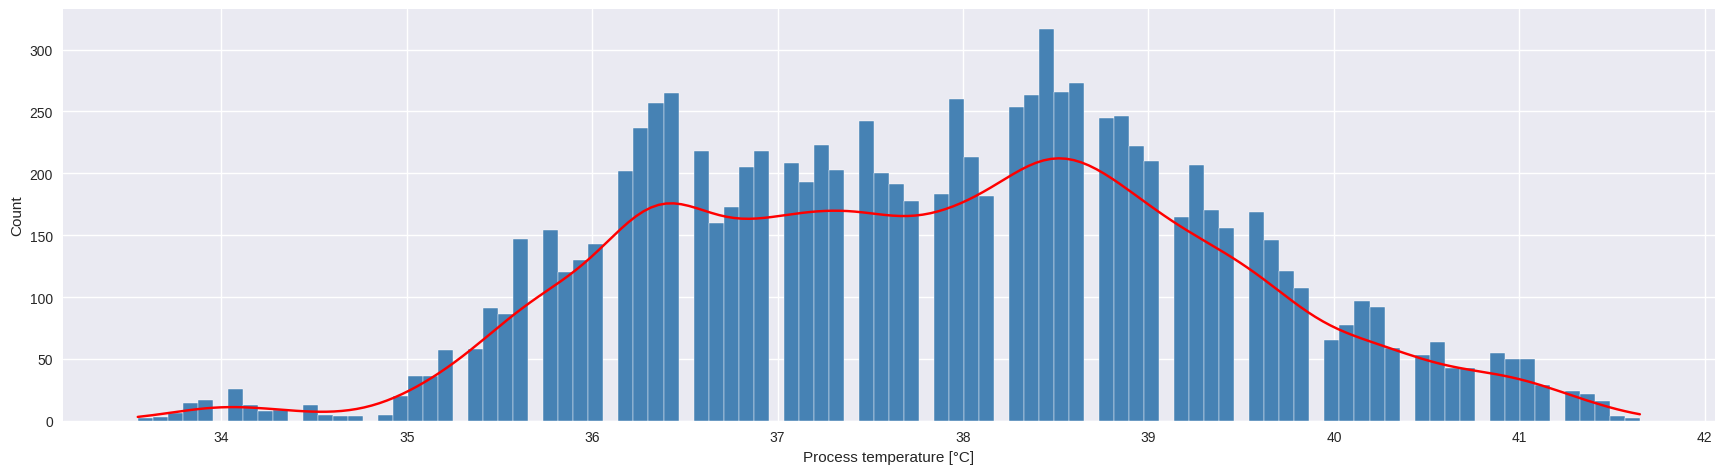

In [ ]:
sns.displot(data=df, x="Process temperature [°C]", kde=True, bins = 100,color = "red", facecolor = "steelblue",height = 5, aspect = 3.5);

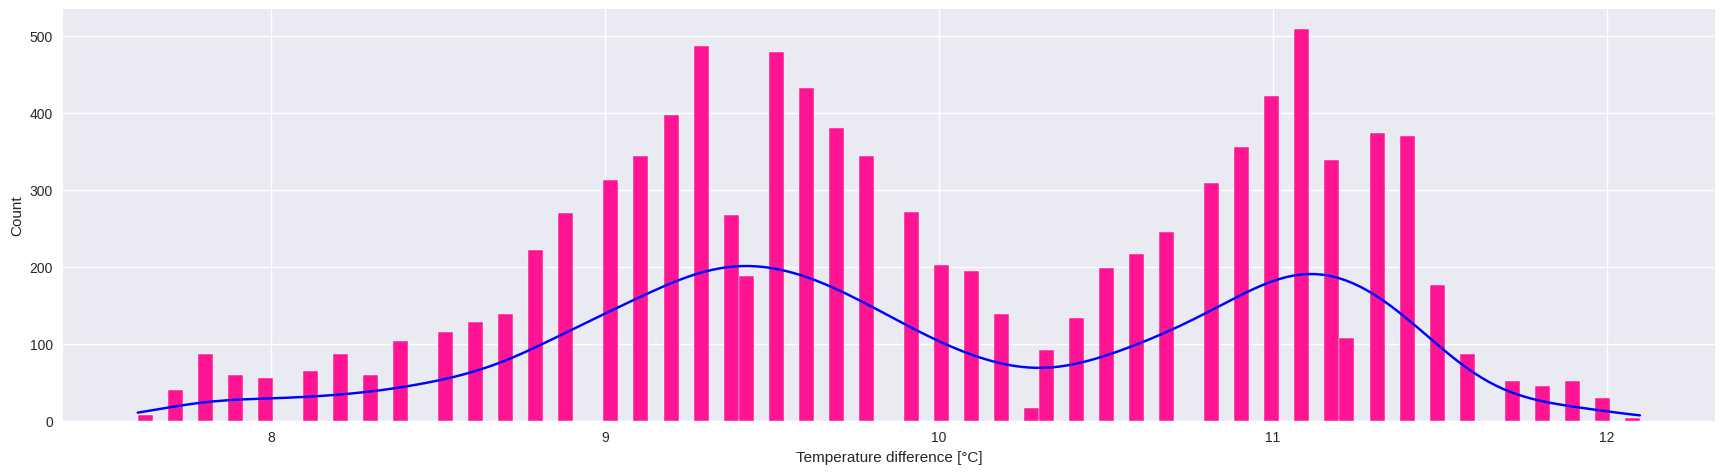

In [ ]:
sns.displot(data=df, x="Temperature difference [°C]", kde=True, bins = 100,color = "blue", facecolor = "DeepPink",height = 5, aspect = 3.5);

In [ ]:
for col in df[['Type','Target','Failure Type']]:
    print(df[col].value_counts())
    print("****"*8)

L    6000
M    2997
H    1003
Name: Type, dtype: int64
********************************
0    9661
1     339
Name: Target, dtype: int64
********************************
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64
********************************


In [ ]:
df.head()

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
0,M,25.95,36.45,1551,42.8,0,0,No Failure,10.5
1,L,26.05,36.55,1408,46.3,3,0,No Failure,10.5
2,L,25.95,36.35,1498,49.4,5,0,No Failure,10.4
3,L,26.05,36.45,1433,39.5,7,0,No Failure,10.4
4,L,26.05,36.55,1408,40.0,9,0,No Failure,10.5


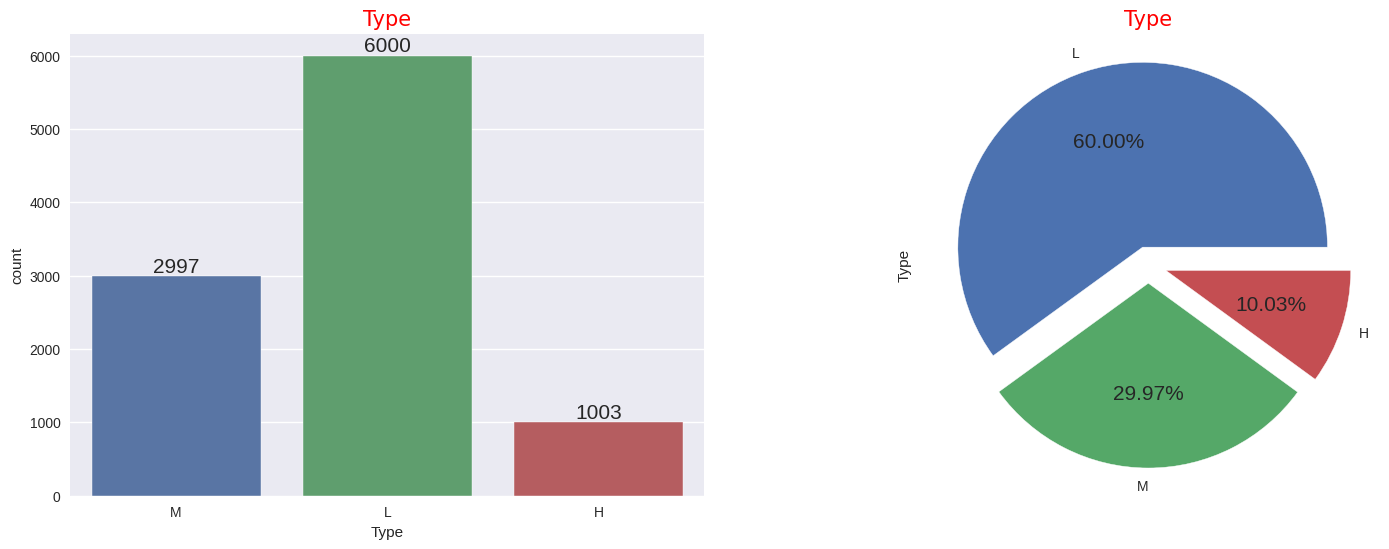

In [ ]:
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='Type', data=df)
ax.bar_label(ax.containers[0])
plt.title("Type", fontsize=20,color='Red',font='Times New Roman')
ax =plt.subplot(1,2,2)
ax=df['Type'].value_counts().plot.pie(explode=[0.1, 0.1,0.1],autopct='%1.2f%%');
ax.set_title(label = "Type", fontsize = 20,color='Red',font='Times New Roman');

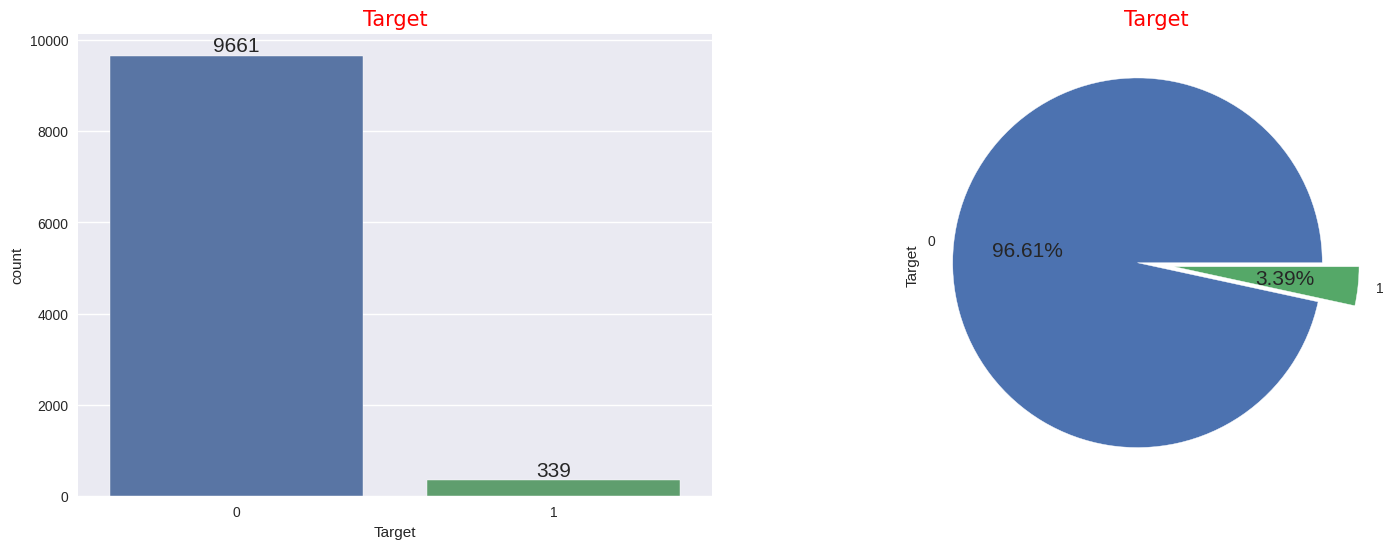

In [ ]:
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='Target', data=df)
ax.bar_label(ax.containers[0])
plt.title("Target", fontsize=20,color='Red',font='Times New Roman')
ax =plt.subplot(1,2,2)
ax=df['Target'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%');
ax.set_title(label = "Target", fontsize = 20,color='Red',font='Times New Roman');

In [ ]:
df.head(2)

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
0,M,25.95,36.45,1551,42.8,0,0,No Failure,10.5
1,L,26.05,36.55,1408,46.3,3,0,No Failure,10.5


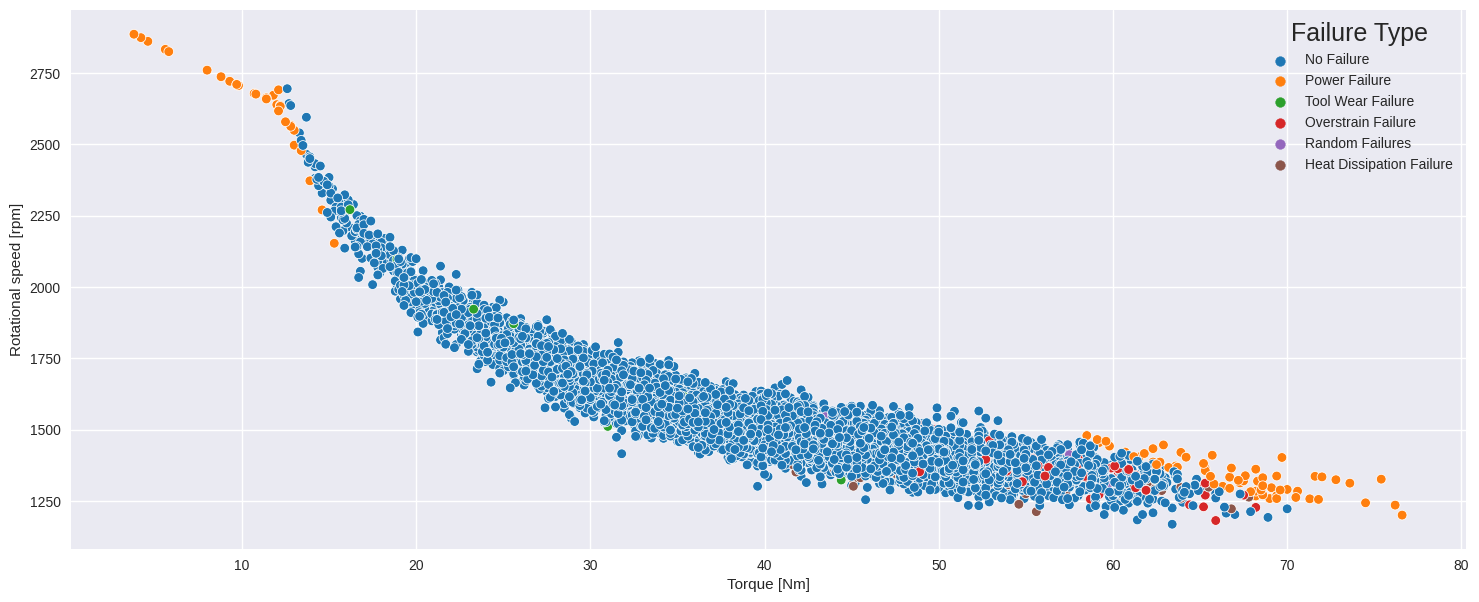

In [ ]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",palette="tab10");

From the chart we can see the map of the failure. Most of the failures have torque < 20Nm or >60Nm.

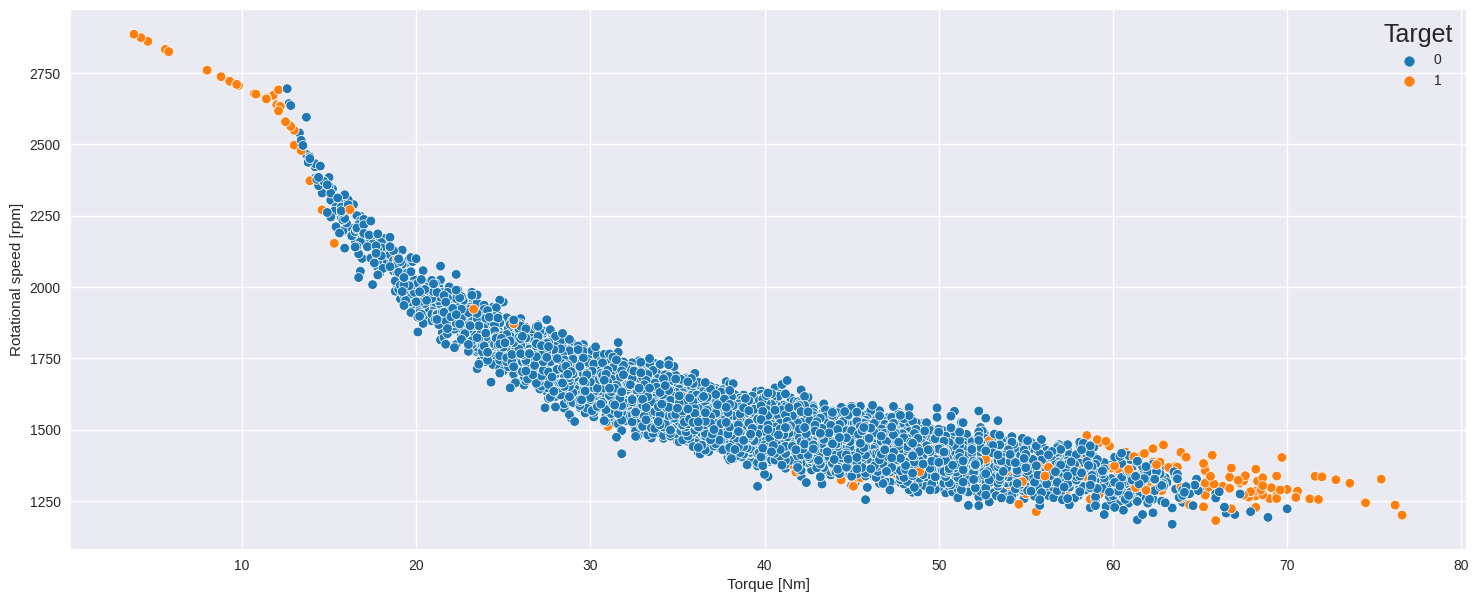

In [ ]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Target",palette="tab10");

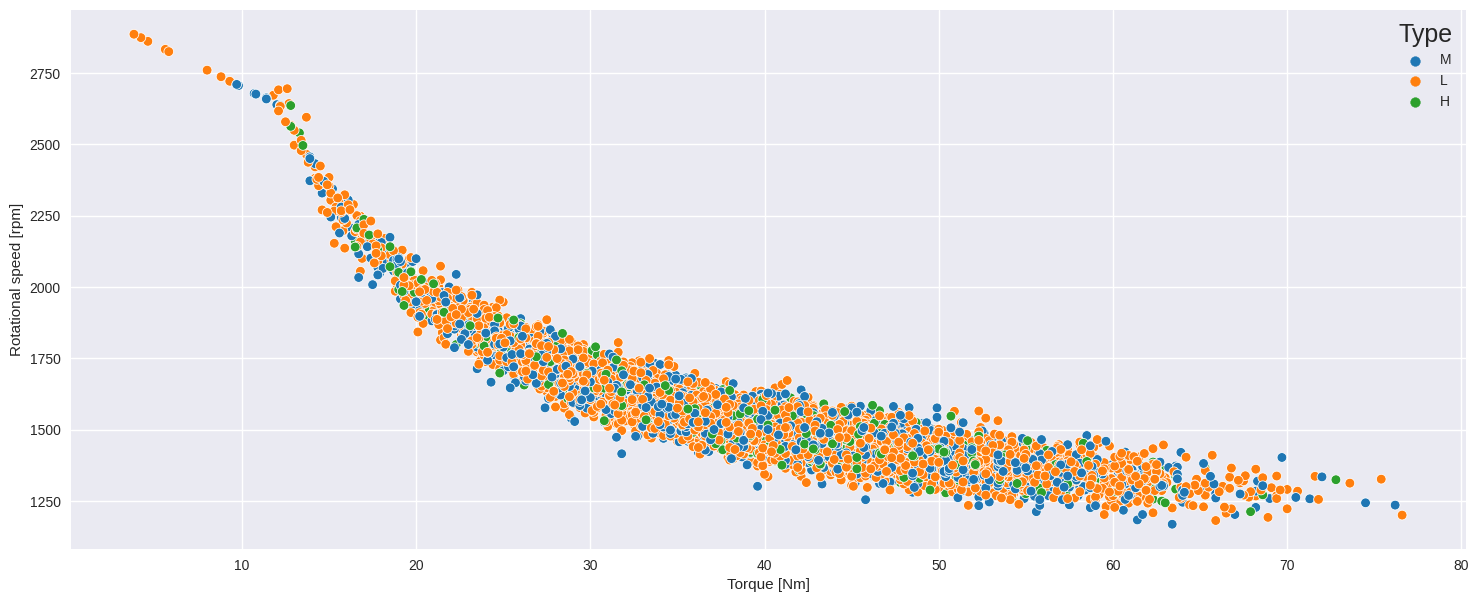

In [ ]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Type",palette="tab10");

In [ ]:
df.head(2)

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
0,M,25.95,36.45,1551,42.8,0,0,No Failure,10.5
1,L,26.05,36.55,1408,46.3,3,0,No Failure,10.5


In [ ]:
#plt.figure(figsize = (15, 6))
#plt.grid()
#sns.swarmplot(df["Torque [Nm]"], df["Failure Type"], hue = df["Failure Type"]);

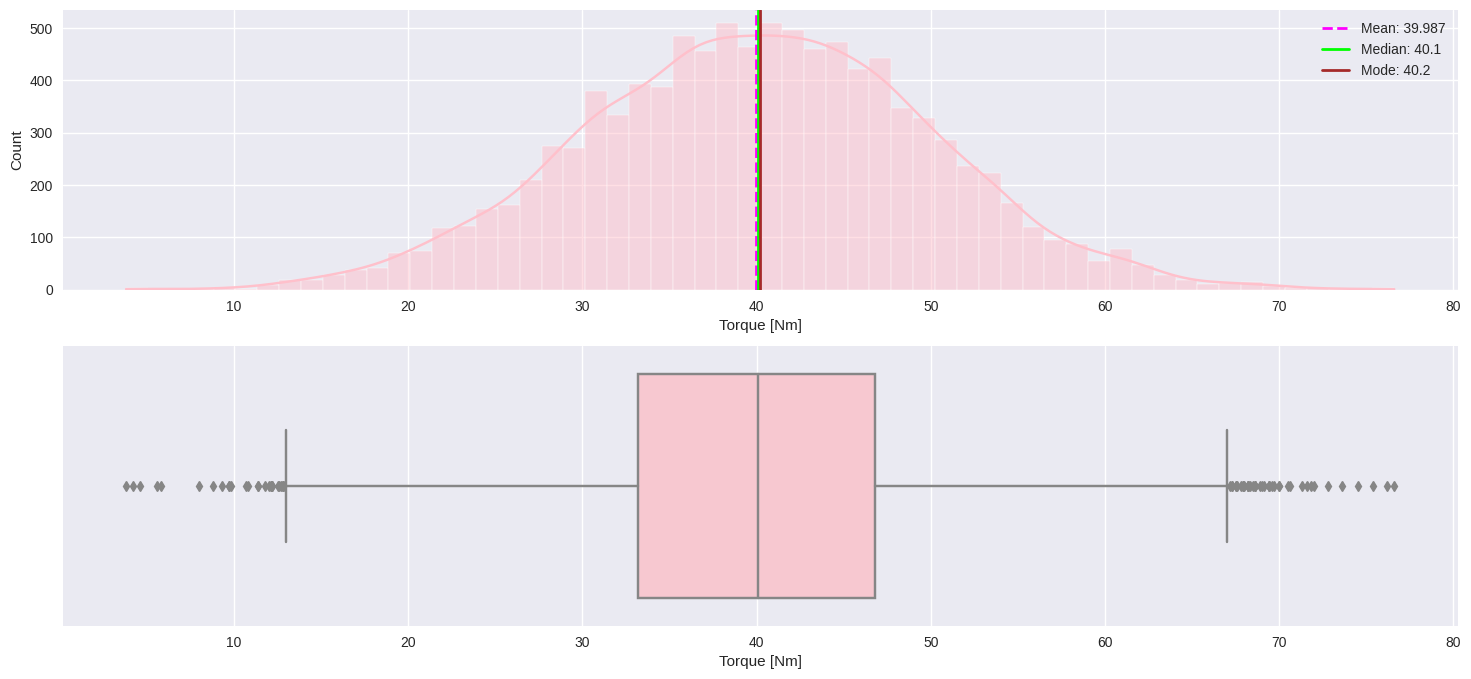

In [ ]:
import statistics

def plot_hist(feature):
    fig, ax = plt.subplots(2, 1, figsize=(18, 8))

    sns.histplot(data = df[feature], kde = True, ax = ax[0],color='pink')

    ax[0].axvline(x = df[feature].mean(), color = 'Magenta', linestyle = '--', linewidth = 2, label = 'Mean: {}'.format(round(df[feature].mean(), 3)))
    ax[0].axvline(x = df[feature].median(), color = 'lime', linewidth = 2, label = 'Median: {}'.format(round(df[feature].median(), 3)))
    ax[0].axvline(x = statistics.mode(df[feature]), color = 'brown', linewidth = 2, label = 'Mode: {}'.format(statistics.mode(df[feature])))
    ax[0].legend()

    sns.boxplot(x = df[feature], ax = ax[1],color='pink')

    plt.show()

plot_hist('Torque [Nm]')

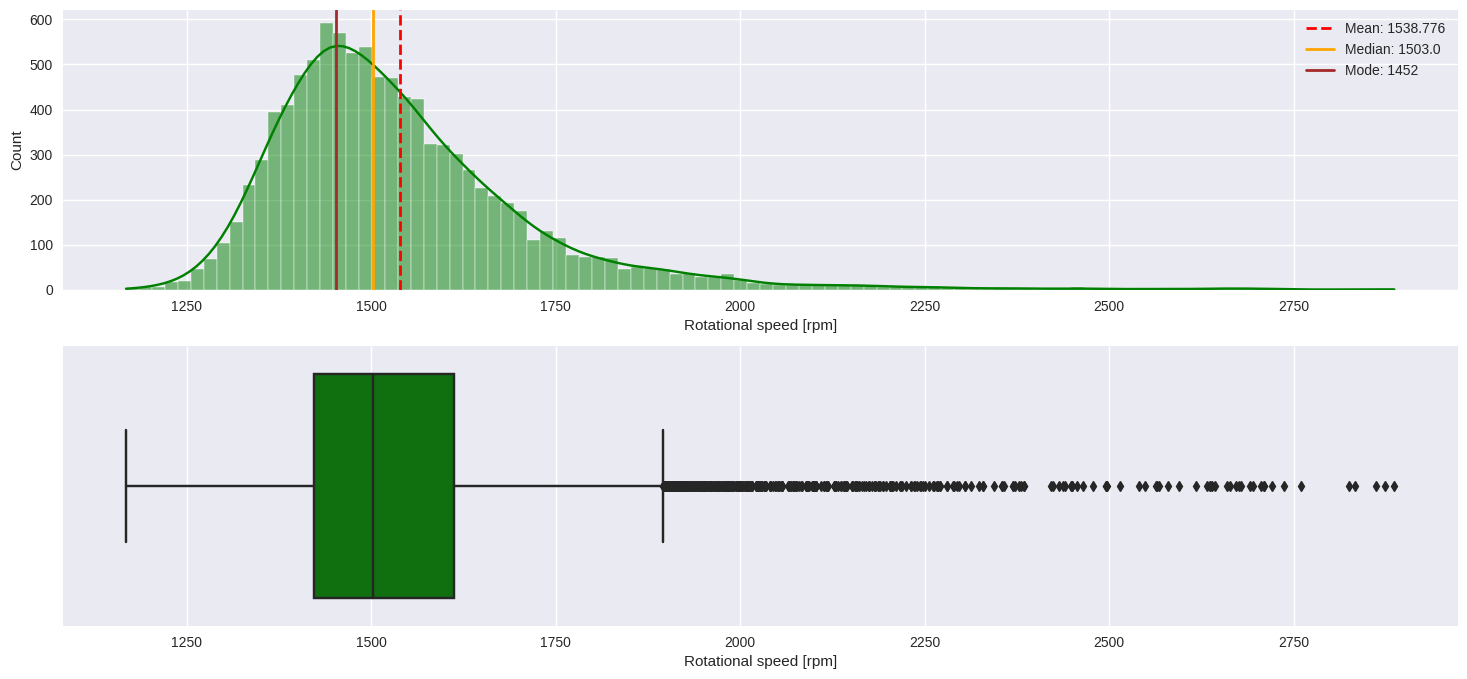

In [ ]:
def plot_hist(feature):
    fig, ax = plt.subplots(2, 1, figsize=(18, 8))

    sns.histplot(data = df[feature], kde = True, ax = ax[0],color='green')

    ax[0].axvline(x = df[feature].mean(), color = 'red', linestyle = '--', linewidth = 2, label = 'Mean: {}'.format(round(df[feature].mean(), 3)))
    ax[0].axvline(x = df[feature].median(), color = 'orange', linewidth = 2, label = 'Median: {}'.format(round(df[feature].median(), 3)))
    ax[0].axvline(x = statistics.mode(df[feature]), color = 'brown', linewidth = 2, label = 'Mode: {}'.format(statistics.mode(df[feature])))
    ax[0].legend()

    sns.boxplot(x = df[feature], ax = ax[1],color='green')

    plt.show()

plot_hist('Rotational speed [rpm]')

In [ ]:
# sns.pairplot(df,hue = "Failure Type");

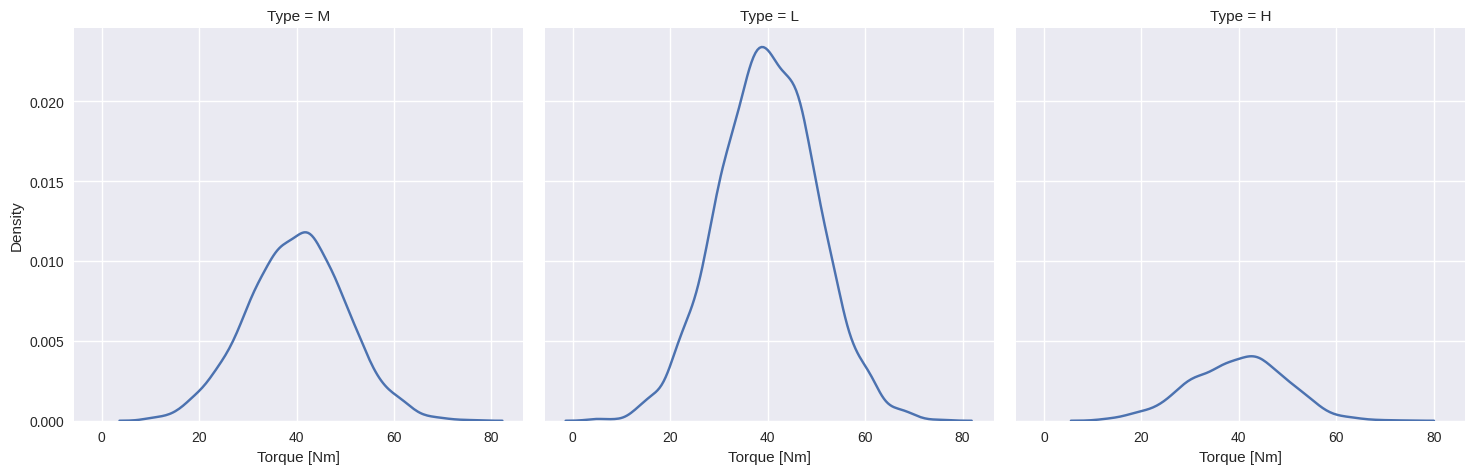

In [ ]:
sns.displot(data=df, x="Torque [Nm]", col="Type", kind="kde");

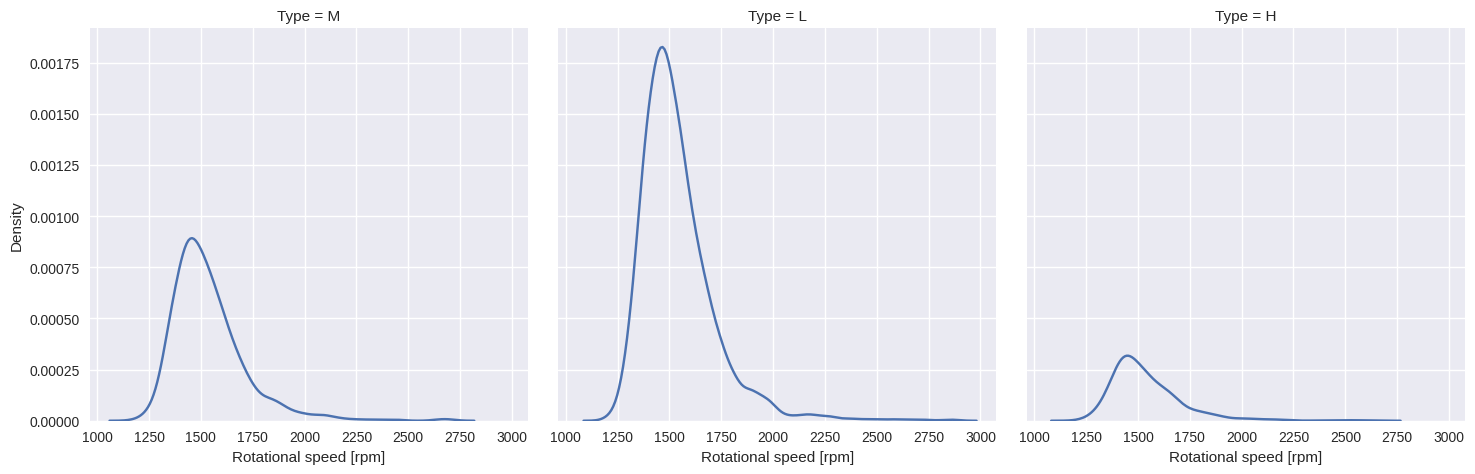

In [ ]:
sns.displot(data=df, x="Rotational speed [rpm]", col="Type", kind="kde");

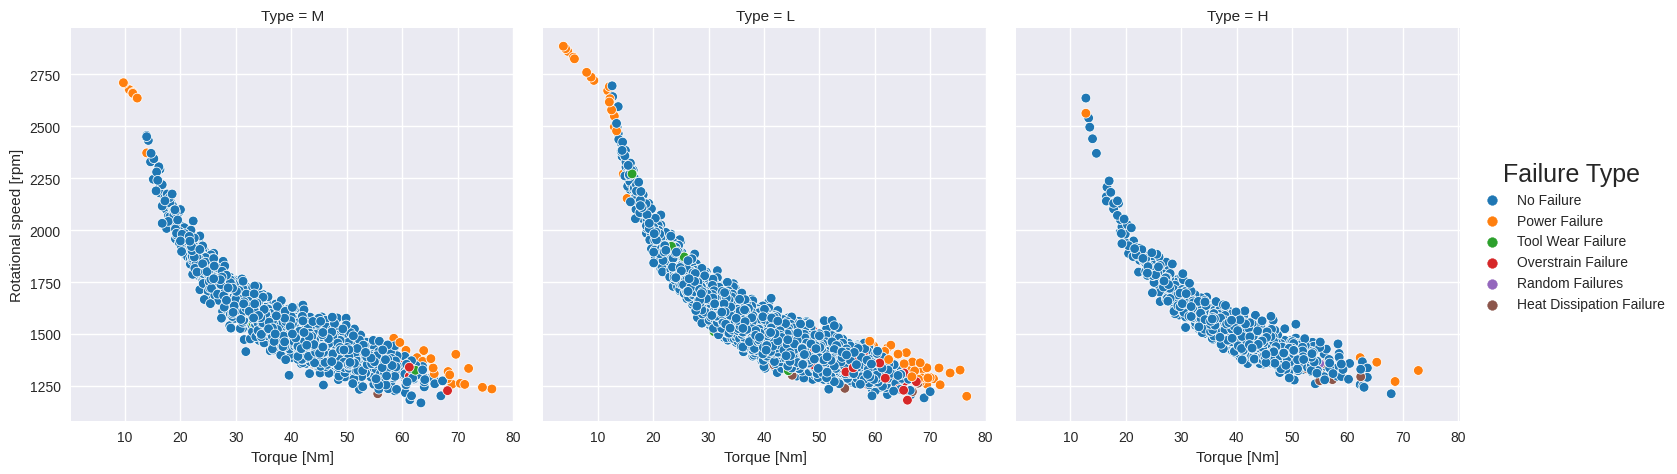

In [ ]:
sns.relplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",col="Type",palette='tab10');

# Machine Learning Part -- Bonus

# Feature Selection

In [ ]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['Type','Failure Type'])
df = encoder.fit_transform(df)
df.head(2)

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
0,1,25.95,36.45,1551,42.8,0,0,1,10.5
1,2,26.05,36.55,1408,46.3,3,0,1,10.5


In [ ]:
from sklearn.preprocessing import LabelEncoder
scaler = LabelEncoder()
df['Failure Type'] = scaler.fit_transform(df['Failure Type'])

In [ ]:
X = df.drop(columns="Failure Type" , axis=1)
y = df["Failure Type"]

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=21)

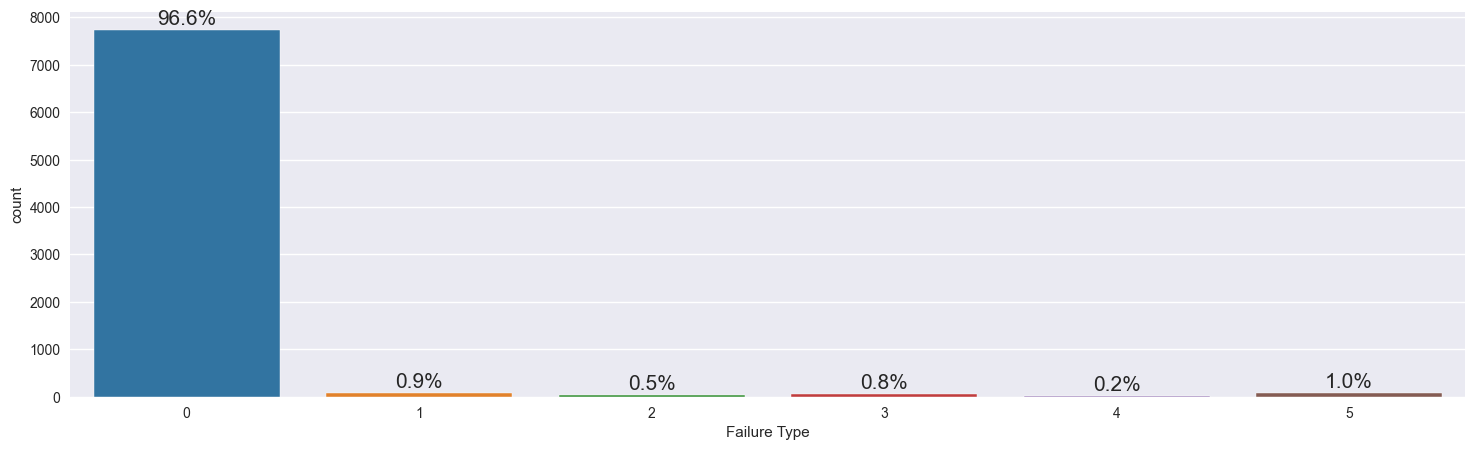

In [ ]:
plt.figure(figsize=(18,5))
ax = sns.countplot(x = y_train, palette = 'tab10')
t= len(y_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

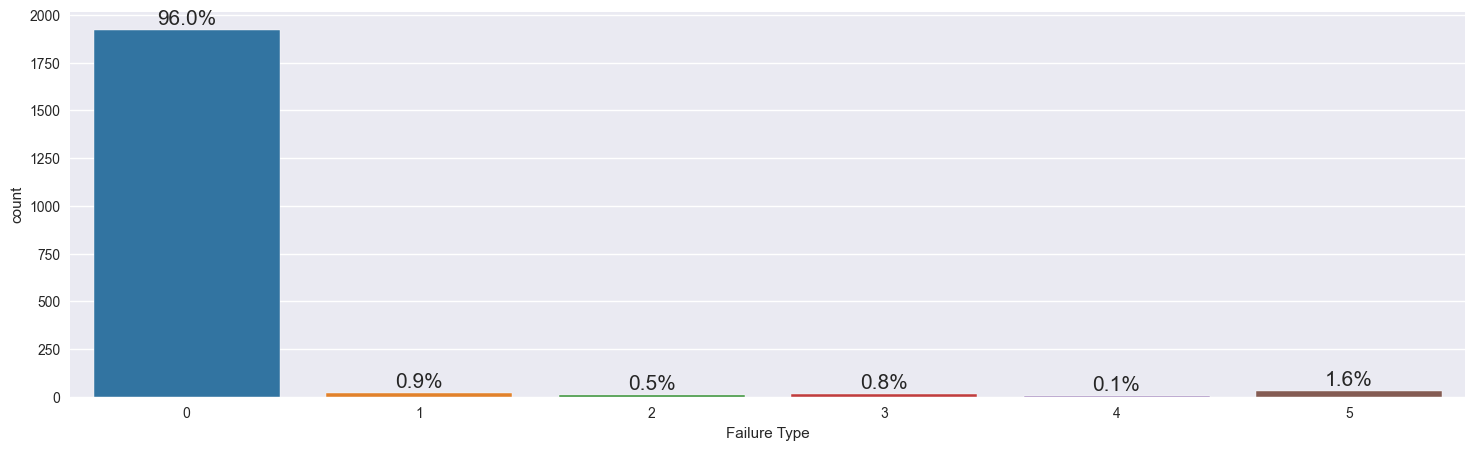

In [ ]:
plt.figure(figsize=(18,5))
ax = sns.countplot(x = y_test, palette = 'tab10')
t= len(y_test)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

# Logistic Regression

Training Accuracy    : 96.74 %
Model Accuracy Score : 96.25 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1921
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00         9
           3       0.67      0.38      0.48        16
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        32

    accuracy                           0.96      2000
   macro avg       0.27      0.23      0.24      2000
weighted avg       0.93      0.96      0.95      2000

--------------------------------------------------------


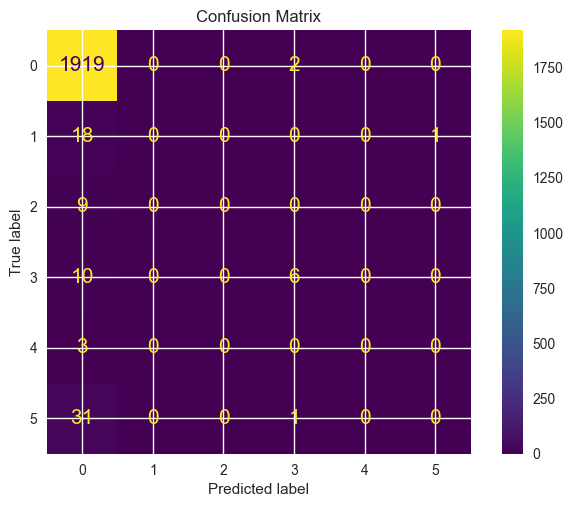

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

log_train = round(logreg.score(X_train, y_train) * 100, 2)
log_accuracy = round(accuracy_score(y_pred_lr, y_test) * 100, 2)


print("Training Accuracy    :",log_train ,"%")
print("Model Accuracy Score :",log_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_lr))
print("\033[1m--------------------------------------------------------\033[0m")
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test);
plt.title('Confusion Matrix');

# Decision Tree Classifier

Training Accuracy    : 100.0 %
Model Accuracy Score : 99.4 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1921
           1       0.85      0.89      0.87        19
           2       0.82      1.00      0.90         9
           3       0.92      0.75      0.83        16
           4       0.00      0.00      0.00         3
           5       0.97      0.97      0.97        32

    accuracy                           0.99      2000
   macro avg       0.76      0.77      0.76      2000
weighted avg       0.99      0.99      0.99      2000

--------------------------------------------------------


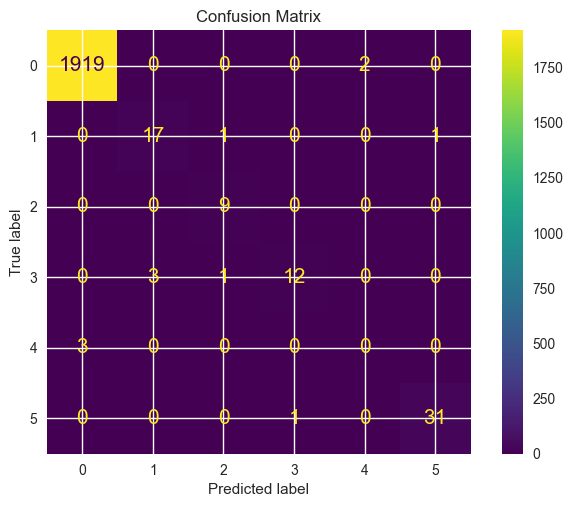

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
decision = DecisionTreeClassifier()
decision.fit(X_train, y_train)
y_pred_dec = decision.predict(X_test)

decision_train = round(decision.score(X_train, y_train) * 100, 2)
decision_accuracy = round(accuracy_score(y_pred_dec, y_test) * 100, 2)

print("Training Accuracy    :",decision_train ,"%")
print("Model Accuracy Score :",decision_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_dec))
print("\033[1m--------------------------------------------------------\033[0m")
ConfusionMatrixDisplay.from_estimator(decision, X_test, y_test);
plt.title('Confusion Matrix');


# Random Forest Classifier

Training Accuracy    : 100.0 %
Model Accuracy Score : 99.6 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1921
           1       0.90      0.95      0.92        19
           2       1.00      0.78      0.88         9
           3       0.88      0.94      0.91        16
           4       0.00      0.00      0.00         3
           5       0.97      0.97      0.97        32

    accuracy                           1.00      2000
   macro avg       0.79      0.77      0.78      2000
weighted avg       0.99      1.00      1.00      2000

--------------------------------------------------------


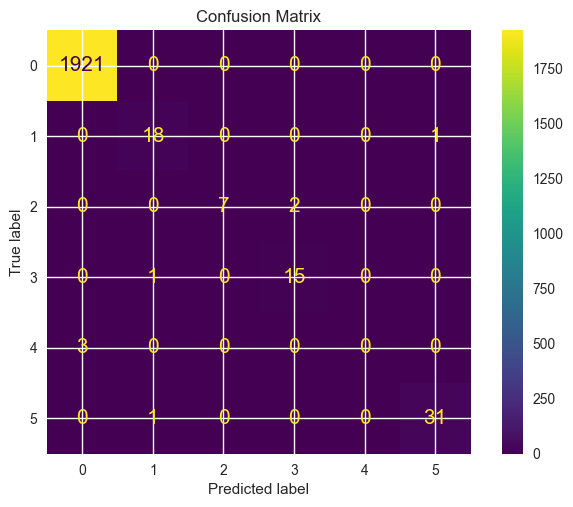

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
random_forest.score(X_train, y_train)

random_forest_train = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_accuracy = round(accuracy_score(y_pred_rf, y_test) * 100, 2)

print("Training Accuracy    :",random_forest_train ,"%")
print("Model Accuracy Score :",random_forest_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_rf))
print("\033[1m--------------------------------------------------------\033[0m")
ConfusionMatrixDisplay.from_estimator(random_forest, X_test, y_test);
plt.title('Confusion Matrix');

# SVM

Training Accuracy    : 96.64 %
Model Accuracy Score : 96.05 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1921
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        32

    accuracy                           0.96      2000
   macro avg       0.16      0.17      0.16      2000
weighted avg       0.92      0.96      0.94      2000

--------------------------------------------------------


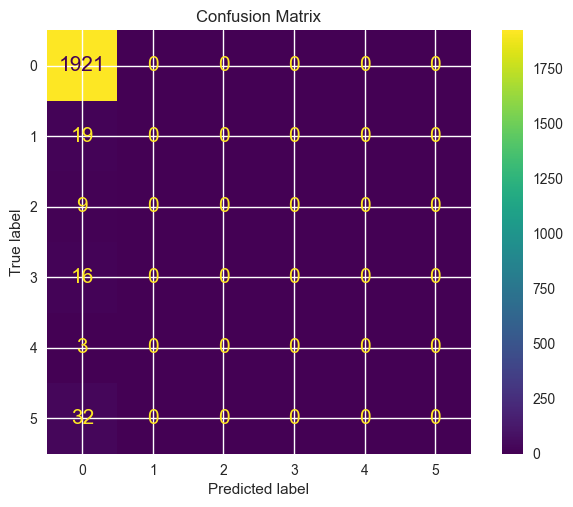

In [ ]:
# Support Vector Machines
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

svc_train = round(svc.score(X_train, y_train) * 100, 2)
svc_accuracy = round(accuracy_score(y_pred_svc, y_test) * 100, 2)

print("Training Accuracy    :",svc_train ,"%")
print("Model Accuracy Score :",svc_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_svc))
print("\033[1m--------------------------------------------------------\033[0m")
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test);
plt.title('Confusion Matrix');

# Model Buiding

In [ ]:
models = pd.DataFrame({
    'Model': [
        'Support Vector Machines', 'Logistic Regression', 'Random Forest',
        'Decision Tree'
    ],

    'Training Accuracy':
    [log_train, svc_train, decision_train, random_forest_train],

    'Model Accuracy Score': [
        log_accuracy, svc_accuracy, decision_accuracy, random_forest_accuracy
    ]
})

In [ ]:
models

,Model,Training Accuracy,Model Accuracy Score
0,Support Vector Machines,96.74,96.25
1,Logistic Regression,96.64,96.05
2,Random Forest,100.00,99.40
3,Decision Tree,100.00,99.60


# Result

In [ ]:
prediction1 = random_forest.predict(X_test)
print(prediction1)

[0 0 0 ... 0 0 0]


In [ ]:
cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction1})
cross_checking.sample(5).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

,Actual,Predicted
5316,0,0
6848,0,0
5625,0,0
4415,0,0
9508,0,0
